In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def cvtToPos(feat_map): # feat_map = [cx, cy, w, h]
    left_upper_x = feat_map[0] - int(feat_map[2]/2)
    left_upper_y = feat_map[1] - int(feat_map[3]/2)
    right_lower_x = feat_map[0] + int(feat_map[2]/2)
    right_lower_y = feat_map[1] + int(feat_map[3]/2)
    return np.array([left_upper_x, left_upper_y, right_lower_x, right_lower_y]).astype(np.int32)

def cvtEdge2Center(rect): # rect = [left_upper_x, left_upper_y, w, h]
    cx = rect[0] + int(rect[2]/2)
    cy = rect[1] + int(rect[3]/2)
    return np.array([cx, cy, rect[2], rect[3]]).astype(np.int32)

In [3]:
# compute feature map positions
def generate_feature_map(imgage_size, feat_size): # #(width, height),(m,n)
    im_w = imgage_size[0]
    im_h = imgage_size[1]
    w = im_w / feat_size[0]
    h = im_h / feat_size[1]

    feat_w = int(w)
    feat_h =int(h)

    feat_map = np.ones([feat_size[0], feat_size[1], 4])

    for i in range(feat_size[0]):
        for j in range(feat_size[1]):

            feat_c_x = int(w / 2 + 1 + i * w)
            feat_c_y = int(h / 2 + 1 + j * h)

            feat_map[i,j,:] = np.array((feat_c_x, feat_c_y, feat_w, feat_h))
        
    return feat_map.astype(np.int32)#(cx, cy, w, h) 

In [4]:
def generate_scales(smin, smax, num_map):
    return smin + (smax - smin) / (num_map - 1) * np.array([k for k in range(num_map+1)])

In [5]:
def generate_default_boxes(imgage_size, feat_map, feat_aspect, scale): #scale = (sk[i], sk[i+1])
    length = imgage_size[0]

    def_boxes = []

    for feat in feat_map:
        for j, ar in enumerate(feat_aspects[i]):
            if ar == 1:
                sk1 = [(scale[0] * scale[1]) ** 0.5, scale[0]]
                for sk in sk1:
                    w = int(length * sk * ar **0.5)
                    h = int(length * sk * (1/ar) ** 0.5)
                    def_boxes.append([feat[0],feat[1], w, h])
            else:
                    w = int(length * scale[0] * ar **0.5)
                    h = int(length * scale[0] * (1/ar) ** 0.5)
                    def_boxes.append([feat[0],feat[1], w, h])
    return np.array(def_boxes) 

In [6]:
def normalize(target, ref): # ref might be default box
    cx = (target[0] - ref[0]) / ref[2]
    cy = (target[1] - ref[1]) / ref[3]
    w = np.log(target[2]/ref[2])
    h = np.log(target[3]/ref[3])
    return np.array([cx, cy, w,h])

def smoothL1(target, ref):
    diffs = target - ref
    for m in range(4):
        if np.abs(diffs[m]) > 1:
            diffs[m] = np.abs(diffs[m])  -  0.5
        else:
            diffs[m] = 0.5 *np.abs(diffs[m]) ** 2
    return diffs.sum()

In [7]:
def box_area(box): #box = [cx, cy, w, h]
    return box[2] * box[3]

def intersection(tar_box, ref_box):# todo: when indexes are out of range
    pixels = 0
    ref_area = cvtToPos(ref_box) # pos = (xmin, ymin, xmax, ymax)
    tar_area = cvtToPos(tar_box)
    
    x_min_max = np.maximum(ref_area[0], tar_area[0])
    x_max_min = np.minimum(ref_area[2], tar_area[2])
    
    intersection_x = np.maximum(0, x_max_min - x_min_max)
    
    y_min_max = np.maximum(ref_area[1], tar_area[1])
    y_max_min = np.minimum(ref_area[3], tar_area[3])
    
    intersection_y = np.maximum(0, y_max_min - y_min_max)
    
    pixels = intersection_x * intersection_y

    return pixels

def IoU(tar_box, ref_box):
    return intersection(tar_box, ref_box)/(box_area(tar_box) + box_area(ref_box))

In [8]:
image_path = 'DSCN2112.JPG'
#image_path = 'test.jpg'
image = Image.open(image_path)
print(image.format, image.size, image.mode)

JPEG (4608, 3456) RGB


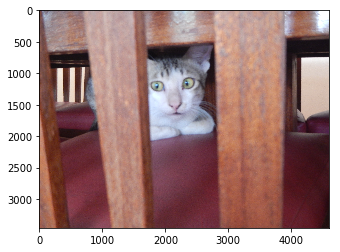

In [9]:
im_original = cv2.imread(image_path)
im_original = cv2.cvtColor(im_original, cv2.COLOR_BGR2RGB)
plt.imshow(im_original)

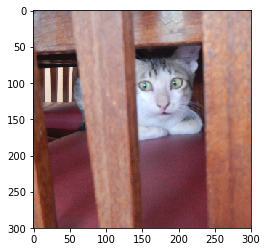

In [10]:
im_size = (300, 300)
x = 100
y = 0
w = min(im_original.shape[0:2])
h = min(im_original.shape[0:2])
im = im_original[y:y+h, x:x+w]
im = cv2.resize(im, im_size)
plt.imshow(im)

In [11]:
feat_nums = [19, 10, 5, 3, 1]
feat_sizes = np.vstack((feat_nums, feat_nums)).T
feat_maps = []
for feat_size in feat_sizes:
    feat_maps.append(generate_feature_map(im.shape[0:2], feat_size))

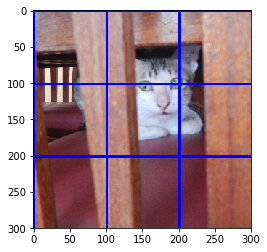

In [12]:
n = 3
color = (0, 0, 255)
for a in feat_maps[n]:
    for b in a:
        rect = cvtToPos(b)
        cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
plt.imshow(im)

In [13]:
scales = generate_scales(0.2, 0.9, len(feat_nums))

In [14]:
aspects = [1, 1/2, 2, 1/3, 3]
aspect_exception = [3, 4]
feat_aspects = []
for i in range(len(feat_maps)):
    if i in aspect_exception:
        feat_aspects.append(aspects[0:3])
    else:
        feat_aspects.append(aspects) 

In [15]:
def_boxes = []
for i, (feat_map, feat_aspect) in enumerate(zip(feat_maps, feat_aspects)):
    scale = (scales[i], scales[i+1])
    def_boxes.append(generate_default_boxes(im.shape[0:2], feat_map.reshape([-1,4]), feat_aspect, scale))
def_box_arr = np.vstack([def_boxes[0], def_boxes[1], def_boxes[2], def_boxes[3], def_boxes[4]])

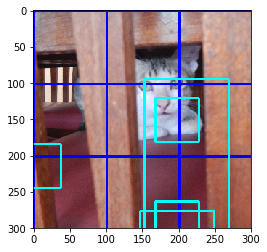

In [16]:
color = (0, 255, 255)
rand_ref = (np.random.rand(5)*len(def_box_arr)).astype(np.int32)
for b in def_box_arr[rand_ref]:
    rect = cvtToPos(b)
    cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
plt.imshow(im)

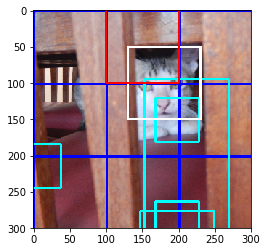

In [17]:
pred_box = np.array([[150, 50, 100, 100]])
gt_box = np.array([[180, 100, 100,100]])

color = (255, 255, 255)
for b in gt_box:
    rect = cvtToPos(b)
    cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
color = (255, 0, 0)
for b in pred_box:
    rect = cvtToPos(b)
    cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
plt.imshow(im)

In [18]:
IoUs = []
for b in def_box_arr:
    IoUs.append(IoU(gt_box[0], b))
IoUs = np.array(IoUs)

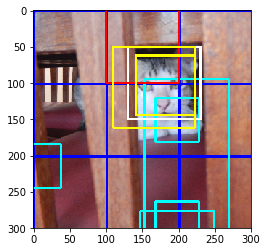

In [19]:
color = (255, 255, 0)
for b in def_box_arr[np.where(IoUs>0.4)]:
    rect = cvtToPos(b)
    cv2.rectangle(im, tuple(rect[0:2]), tuple(rect[2:4]), color, thickness=2)
plt.imshow(im)

In [20]:
norm_gt_box = []
norm_pred_box = []

for d in def_box_arr:
    norm_gt_box.append(normalize(gt_box[0], d))
    norm_pred_box.append(normalize(pred_box[0], d)) 

In [23]:
loss = 0
for j in np.where(IoUs>0.5)[0]:
    loss += smoothL1(norm_pred_box[j], norm_gt_box[j])

In [24]:
loss

0